In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
import scipy
from pulp import *
from math import *

In [3]:
def ent_rate_memory_exact(p_list,W):
#     p_list = [p]*N
    N = len(p_list) # number of links (or number of repeaters -1)
    Q = np.zeros((W,N)) 
    for k, p_k in enumerate(p_list):
        for i in range(W):
            Q[i,k] = comb(W,i+1)* p_k**(i+1) * (1-p_k)**(W-i-1)

    P = np.zeros((W,N)) 
    P[:,0] = Q[:,0]     
    for k in range(1,N):
        for i in range(W):
            P[i,k] = P[i,k-1]* np.sum(Q[i:,k]) + Q[i,k]* np.sum(P[i+1:,k-1])

    return np.sum(np.arange(1,W+1)*P[:,N-1])

def ent_rate_minimize(p,p0,N,W):
    p_list = [p]*N
#     N = len(p_list) # number of links (or number of repeaters -1)
    Q = np.zeros((W,N)) 
    for k, p_k in enumerate(p_list):
        for i in range(W):
            Q[i,k] = comb(W,i+1)* p_k**(i+1) * (1-p_k)**(W-i-1)

    P = np.zeros((W,N)) 
    P[:,0] = Q[:,0]     
    for k in range(1,N):
        for i in range(W):
            P[i,k] = P[i,k-1]* np.sum(Q[i:,k]) + Q[i,k]* np.sum(P[i+1:,k-1])

    return (np.sum(np.arange(1,W+1)*P[:,N-1])-p0)**2

# p = 0.2
# N = 100
# w = 100
# p0 = w*0.1
# # ent_rate_memory_exact(p,N,w)/w
# p_res = scipy.optimize.fmin(ent_rate_minimize, x0=0.5, args=(p0,N,w))

# print(p_res,ent_rate_memory_exact(p_res,N,w))

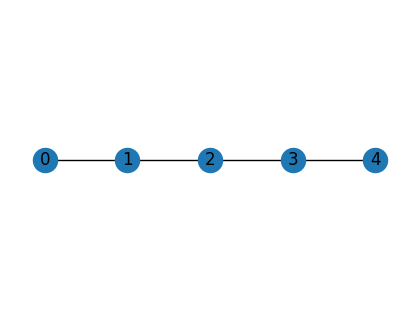

80.0


In [134]:
# network graph
N = 5# number of nodes
node_list = np.arange(N)
G = nx.Graph()
G.add_nodes_from(node_list)
p = 40
adj_mat = np.zeros((N,N))
for n in range(N-1):
    adj_mat[n,n+1] = p
adj_mat += adj_mat.T

pos = dict()
for node in range(N):
    pos[node] = (node,0)
    
G = nx.from_numpy_array(adj_mat)
plt.figure(figsize=(4,3))
nx.draw(G, pos = pos,  with_labels=True)
plt.show()
print(nx.shortest_path_length(G, source=1, target=3, weight="weight"))

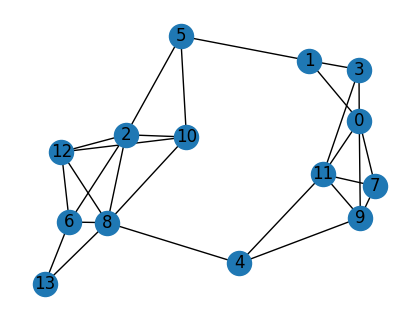

39.30263446402345


In [309]:
# random network graph
N = 14# number of nodes
node_list = np.arange(N)

L0 = 100
length = L0
width = L0
dmax = 0.4*L0
# np.random.seed = 3
random.seed(20)
pos = dict()
for node in range(N):
    pos[node] = (random.random()*length,random.random()*width)
    
G = nx.random_geometric_graph(N, dmax, dim=2, pos=pos, p=2)

weights = dict()
transmission = dict()
for e in G.edges():
    dist = np.linalg.norm([pos[e[0]][0]-pos[e[1]][0],pos[e[0]][1]-pos[e[1]][1]])
    weights[e] = dist
    transmission[e] = 10**(-0.2*dist/10)
    
nx.set_edge_attributes(G, values = weights, name = 'weight')
nx.set_edge_attributes(G, values = transmission, name = 'trans')

plt.figure(figsize=(4,3))
nx.draw(G,pos,with_labels=True)
plt.show()

print(nx.shortest_path_length(G, source=4, target=8, weight="weight"))

In [320]:
Nmax = 4
Rmin = 0.1
w_list = range(1,20)

δ = 1e-2
cons = []
cons.append({'type': 'ineq','fun': lambda x: x-δ })
cons.append({'type': 'ineq','fun': lambda x: (1-δ)-x })

######## max link distance
Lmax_w = np.zeros(len(w_list))
for i_w, memory in enumerate(w_list):
    p_res = scipy.optimize.fmin(ent_rate_minimize, x0=.99, args=(Rmin,Nmax,memory),disp=False)
    f = scipy.optimize.minimize(ent_rate_minimize, x0=0.99, args=(Rmin,Nmax,memory), constraints=cons , method='COBYLA')
# #     p_res = f.x
    print(-50*np.log10(f.x),-50*np.log10(p_res))
    Lmax_w[i_w] = -50*np.log10(p_res)
#     print(p_res,ent_rate_memory_exact([p_res]*Nmax,memory))
###########################
print(Lmax_w)

[12.49595475] [12.49828491]
[23.53329548] [23.53604098]
[30.96513555] [30.94944884]
[36.51623682] [nan]
[40.9378643] [nan]
[44.57782733] [44.6060619]
[47.72796773] [47.75506721]
[50.4727387] [50.49568032]
[52.9123973] [52.92481658]
[55.10555012] [55.12213528]
[57.16001656] [57.12542446]


/var/folders/3z/cqx0rxzn29116x691bywsldm0000gn/T/ipykernel_94654/4109676404.py:16: RuntimeWarning: invalid value encountered in log10
  print(-50*np.log10(f.x),-50*np.log10(p_res))
/var/folders/3z/cqx0rxzn29116x691bywsldm0000gn/T/ipykernel_94654/4109676404.py:17: RuntimeWarning: invalid value encountered in log10
  Lmax_w[i_w] = -50*np.log10(p_res)


[58.9071866] [58.94870953]
[60.6023597] [60.62877521]
[62.23708328] [62.19063752]
[63.68115232] [63.63628422]
[65.07798074] [65.01675011]
[66.25263947] [66.312247]
[67.54885795] [67.50113932]
[68.61810772] [68.65953258]
[12.49828491 23.53604098 30.94944884         nan         nan 44.6060619
 47.75506721 50.49568032 52.92481658 55.12213528 57.12542446 58.94870953
 60.62877521 62.19063752 63.63628422 65.01675011 66.312247   67.50113932
 68.65953258]


In [321]:
Lmax_w[3] = 36.51623682
Lmax_w[4] = 40.9378643

In [322]:

prob = LpProblem("memory", LpMinimize)

D0 = 40
D = D0*np.ones(N)
s_list = [13,12,10] # source
t_list = [9,11,7] # destination
C = len(s_list)

# indices: (superscript, subscript)
R_list = np.array(list(set(node_list)-set(np.concatenate((s_list,t_list)))))

x = LpVariable.matrix("x", (list(range(C)),list(range(len(w_list))),list(range(N)),list(range(N))), 0, 1, LpInteger)
# yu = LpVariable.matrix("yu", list(range(N)), 0, 1, LpInteger)
yu = LpVariable.matrix("yu", list(range(N)), 0, None, LpInteger)

for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]
    for memory in range(len(w_list)):
        
        number = 0
        for n1 in R_list:
            
            if nx.has_path(G, source=s, target=n1):
                l_uv = nx.shortest_path_length(G, source=s, target=n1, weight="weight")
                prob += l_uv*x[user_pair][memory][s][n1] <= Lmax_w[memory] 
            else:
                prob += x[user_pair][memory][s][n1] == 0 

            if nx.has_path(G, source=n1, target=t):
                l_uv = nx.shortest_path_length(G, source=n1, target=t, weight="weight")
                prob += l_uv*x[user_pair][memory][n1][t] <= Lmax_w[memory]  
            else:
                prob += x[user_pair][memory][n1][t] == 0 

            path = x[user_pair][memory][n1][t] - x[user_pair][memory][s][n1]
            number += x[user_pair][memory][s][n1]+ x[user_pair][memory][n1][t]
            for n2 in R_list:
                if n2 != n1:
                    if nx.has_path(G, source=n1, target=n2):
                        l_uv = nx.shortest_path_length(G, source=n1, target=n2, weight="weight")
                        prob += l_uv*x[user_pair][memory][n1][n2] <= Lmax_w[memory] 
                    else:
                        prob += x[user_pair][memory][n1][n2] == 0 

                    path += x[user_pair][memory][n1][n2] - x[user_pair][memory][n2][n1]
                    number += x[user_pair][memory][n1][n2]

            prob += path == 0 
        prob += number <= Nmax  
        prob += nx.shortest_path_length(G, source=s, target=t, weight="weight")*x[user_pair][memory][s][t] <= Lmax_w[memory]  

for user_pair in range(C):
    w_user = 0 
    s = s_list[user_pair]
    t = t_list[user_pair]
    path_s = 0
    path_t = 0
    for memory in range(len(w_list)):        
        w_user += w_list[memory]*x[user_pair][memory][s][t]
        path_s += x[user_pair][memory][s][t]
        path_t += x[user_pair][memory][s][t]
        for n1 in R_list:
            w_user += w_list[memory]*x[user_pair][memory][s][n1]
            path_s += x[user_pair][memory][s][n1]
            path_t += x[user_pair][memory][n1][t]

    prob += w_user <= yu[s]  
    prob += yu[s] == yu[t]  
    prob += path_s == 1 
    prob += path_t == 1 
    
for n1 in R_list:
    y1_const = 0
    y2_const = 0
    for user_pair in range(C):
        s = s_list[user_pair]
        t = t_list[user_pair]
        for memory in range(len(w_list)):        
            y1_const += w_list[memory]*x[user_pair][memory][n1][t]
            y2_const += w_list[memory]*x[user_pair][memory][s][n1]
            for n2 in R_list:
                if n2 != n1:
                    y1_const += w_list[memory]*x[user_pair][memory][n1][n2]
                    y2_const += w_list[memory]*x[user_pair][memory][n2][n1]
                    
#     prob += y1_const <= D[n1]*yu[n1]  
#     prob += y2_const <= D[n1]*yu[n1]                   
    prob += y1_const <= yu[n1]  
    prob += y2_const <= yu[n1] 


for n1 in range(N):
    for n2 in range(N):
        if n2 != n1:
            for user_pair in range(C):
                x_const = 0
                for memory in range(len(w_list)):
                    x_const += x[user_pair][memory][n1][n2]

                prob += x_const <= 1 


# y_sum = 0
# for n1 in range(N):
#     prob +=  yu[n1] <= D0 
#     prob +=  0 <= yu[n1]  
#     if (n1 not in s_list) and (n1 not in t_list):
#         y_sum += yu[n1]

# The objective is the total cost
prob += lpSum(yu) #- wx_sum
# Solve the problem
prob.solve()

print("Minimum total cost:", prob.objective.value())


x_opt = np.zeros((C,len(w_list),N,N))
y_opt = np.zeros(N)
for i in range(N):
    y_opt[i] = value(yu[i])
    for j in range(N):
        for user_pair in range(C):
            for memory in range(len(w_list)):
                x_opt[user_pair,memory,i,j] = value(x[user_pair][memory][i][j])



Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/hshapour/.conda/envs/QR/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/3z/cqx0rxzn29116x691bywsldm0000gn/T/51d9b15e67974c978ede6238eb145aae-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/3z/cqx0rxzn29116x691bywsldm0000gn/T/51d9b15e67974c978ede6238eb145aae-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5253 COLUMNS
At line 60839 RHS
At line 66088 BOUNDS
At line 76477 ENDATA
Problem MODEL has 5248 rows, 10388 columns and 34795 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 8.66347 - 0.06 seconds
Cgl0003I 4 fixed, 11 tightened bounds, 23 strengthened rows, 4 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 14 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 23 strengthened rows, 0 substitutions
Cgl0003I 0 f

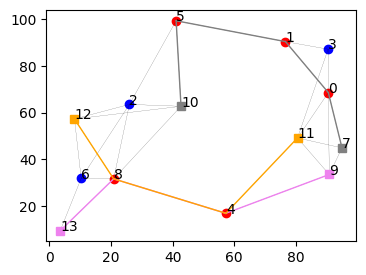

[ 5.  5.  0.  0. 10.  5.  0.  5. 10.  5.  5.  5.  5.  5.]


In [323]:
plt.figure(figsize=(4,3))
for i,y in enumerate(y_opt):
    if i not in np.concatenate((s_list,t_list)):
        if y > 0:
            plt.plot(pos[i][0],pos[i][1],"ro")#,markersize=5)
            plt.text(pos[i][0],pos[i][1],"%d" % i)
        else:
            plt.plot(pos[i][0],pos[i][1],"bo")
            plt.text(pos[i][0],pos[i][1],"%d" % i)
            
for e in G.edges():
    plt.plot([ pos[e[0]][0],pos[e[1]][0] ], [ pos[e[0]][1],pos[e[1]][1] ], color = "black", linewidth=0.1)
            
colors = ["violet","orange","gray"]
for user_pair in range(C):
    s = s_list[user_pair]
    plt.plot(pos[s][0],pos[s][1],"s", color = colors[user_pair])
    plt.text(pos[s][0],pos[s][1],"%d" % s)
    t = t_list[user_pair]
    plt.plot(pos[t][0],pos[t][1],"s", color = colors[user_pair])
    plt.text(pos[t][0],pos[t][1],"%d" % t)
    for memory in range(len(w_list)):

        edges = np.argwhere(x_opt[user_pair,memory,:,:]>0)
        path_output = []
        for e in edges:
            if G.has_edge(e[0],e[1]):
                plt.plot([ pos[e[0]][0],pos[e[1]][0] ], [ pos[e[0]][1],pos[e[1]][1] ], color = colors[user_pair], linewidth=1)
                path_output.append(e)
            else:
                path = nx.shortest_path(G, source=e[0], target=e[1], weight="weight")
                path_output.append(path)
                for i in range(len(path)-1):
                    e1 = path[i]
                    e2 = path[i+1]
                    plt.plot([ pos[e1][0],pos[e2][0] ], [ pos[e1][1],pos[e2][1] ], color = colors[user_pair], linewidth=1)

#         print((s_list[user_pair],t_list[user_pair]),":",path_output)
plt.show()
print(y_opt)


In [324]:
for user_pair in range(C):
    s = s_list[user_pair]
    for memory in range(len(w_list)):
        if np.sum(x_opt[user_pair,memory,s,~np.isnan(x_opt[user_pair,memory,s,:])])>0:
            w_ind = memory
            w_res = w_list[memory]
            
    # print(np.sum(x_opt[user_pair][:][s][:],axis=0))
    edges = np.argwhere(x_opt[user_pair,w_ind,:,:]>0)
    path_prob = []
    path_dist = []
    path_output = []
    for e in edges:
        path_prob.append(10**(-0.2*nx.shortest_path_length(G, source=e[0], target=e[1], weight="weight")/10) )
        path_dist.append( nx.shortest_path_length(G, source=e[0], target=e[1], weight="weight") )
        if G.has_edge(e[0],e[1]):
            path_output.append(list(e))
        else:
            path = nx.shortest_path(G, source=e[0], target=e[1], weight="weight")
            path_output.append(path)
#     print(edges)
    print((s_list[user_pair],t_list[user_pair]),":",w_res,path_output)
    print(Rmin, ent_rate_memory_exact(path_prob,w_res))
#     print(path_prob)



(13, 9) : 5 [[4, 9], [8, 4], [13, 8]]
0.1 0.311696953064112
(12, 11) : 5 [[4, 11], [8, 4], [12, 8]]
0.1 0.28573906027783785
(10, 7) : 5 [[0, 7], [1, 0], [5, 1], [10, 5]]
0.1 0.3106163581120459
